In [93]:
import numpy as np
import matplotlib.pyplot as plt
import napari

In [64]:
#Create volume data

w0=256 #width of full array
w1 = int(w0/2) # -w0/2 to +w0/2
w2 = int(w0/16) # width of feature in the middle

x_mg, y_mg, z_mg = np.mgrid[-w1:w1 , -w1:w1 , -w1:w1]

#cube in middle
data3d = ( (np.abs(x_mg)<=w2)*(np.abs(y_mg)<=w2)*(np.abs(z_mg)<=w2) )*1.0


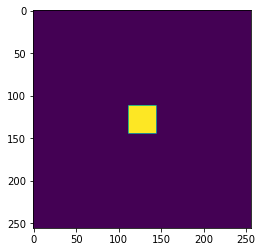

In [65]:
plt.imshow(data3d[w1,:,:])

## PSF

In [66]:
#convolute with a 3D gaussian centered at (0,0,0)
w_psf = 16
w_psf_half = int(w_psf/2)

x__psf_mg, y_psf_mg, z_psf_mg = np.mgrid[-w_psf_half:w_psf_half , -w_psf_half:w_psf_half , -w_psf_half:w_psf_half]
gauss3d = np.exp( (np.multiply(x__psf_mg,x__psf_mg)+np.multiply(y_psf_mg,y_psf_mg) +np.multiply(z_psf_mg,z_psf_mg) )/ -8 )

In [67]:
gauss3d.shape

(16, 16, 16)

In [108]:
psf_norm = gauss3d/gauss3d.sum()

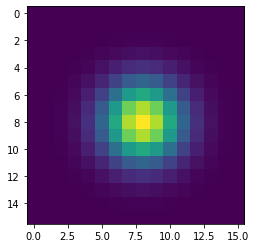

In [109]:
plt.imshow(psf_norm[w_psf_half,:,:])

In [110]:
from scipy import signal
#Convolute data with gaussian
data3dconv = signal.convolve(data3d, gauss3d , mode='same')

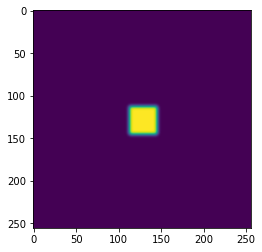

In [111]:
plt.imshow(data3dconv[w1,:,:])

In [112]:
data3dconv.max()

125.96494219803614

In [113]:
#Add some noise

#Use poisson noise
#https://numpy.org/doc/stable/reference/random/index.html#random-quick-start
from numpy.random import default_rng
rng = default_rng()

noise3d = rng.poisson(lam=25, size=data3dconv.shape)

data3dconvnoise = data3dconv + noise3d*data3dconv.max()*0.002

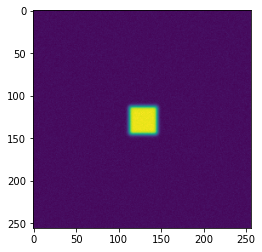

In [114]:
plt.imshow(data3dconvnoise[w1,:,:])

In [115]:
data3dconvnoise.shape

(256, 256, 256)

By this point `data3dconvnoise` should contain the simulated data

## Richardson-Lucy (using skimage.restoration)

5 iterations

In [118]:
niter=10

In [119]:
import skimage.restoration
deconv_skimageRL = skimage.restoration.richardson_lucy(data3dconvnoise,psf_norm, niter, clip=False)

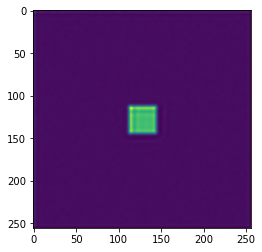

In [120]:
plt.imshow(deconv_skimageRL[w1,:,:])

## block

Select middle block, run RL, compare result with full block

In [121]:
slice_z0 , slice_z1 , slice_y0, slice_y1, slice_x0, slice_x1 = 64, 192, 64, 192, 64, 192

In [122]:
block = data3dconvnoise[slice_z0:slice_z1 , slice_y0:slice_y1, slice_x0:slice_x1 ]

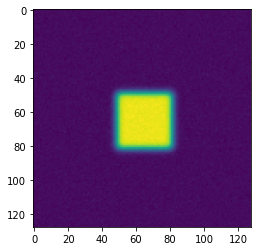

In [123]:
plt.imshow(block[64,:,:])

In [124]:
block.shape

(128, 128, 128)

In [125]:
block_skimageRL = skimage.restoration.richardson_lucy(block,psf_norm, niter, clip=False)

In [126]:
block_skimageRL.shape

(128, 128, 128)

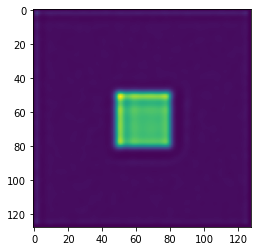

In [127]:
plt.imshow(block_skimageRL[64,:,:])

Get difference squared in result

In [128]:
diffsq = np.power(block_skimageRL-deconv_skimageRL[slice_z0:slice_z1 , slice_y0:slice_y1, slice_x0:slice_x1 ], 2)

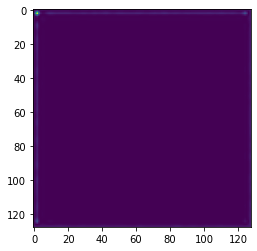

In [129]:
plt.imshow(diffsq[64,:,:])

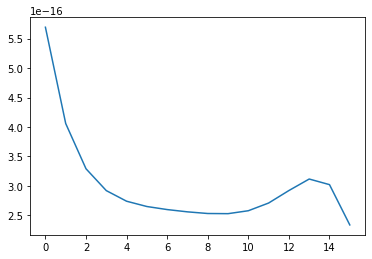

In [135]:
plt.plot(diffsq[64,64,64:80])

In [130]:
napari.view_image(diffsq)

Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(0.0, 63.5, 63.5), zoom=3.762890625, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(1.0, 1.0, 0.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=3, ndisplay=2, last_used=0, range=((0.0, 128.0, 1.0), (0.0, 128.0, 1.0), (0.0, 128.0, 1.0)), current_step=(64, 64, 64), order=(0, 1, 2), axis_labels=('0', '1', '2')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'diffsq' at 0x2c4dc263130>], scale_bar=ScaleBar(visible=False, colored=False, ticks=True, position=<Position.BOTTOM_RIGHT: 'bottom_right'>, font_size=10, unit=None), text_overlay=TextOverlay(visible=False, color=(0.5, 0.5, 0.5, 1.0), font_size=10, position=<TextOverlayPosition.TOP_LEFT: 'top_left'>, text=''), overlays=Overlays(interaction_box=InteractionBox(points=None, show=False, show_handle=False, show_vertices=False, sele